In [10]:
import torch
import os
import json
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import pandas as pd
cudnn.benchmark = True  # fire on all cylinders
from sklearn.metrics import roc_auc_score, roc_curve
import sys
from torchvision import datasets, transforms as T 
import seaborn as sns

sys.path.insert(0, '..')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import utils

## Preparation

In [11]:
dataset_path = '../../tdc_datasets'
task = 'detection'
MODEL_FILEDIR = os.path.join(dataset_path, task, 'train')
EXTRACTED_DIR = './extracted_features'
NUM_MODEL = 500
model_classes = ['MNIST_Network', 'SimpleViT', 'WideResNet']
clean_or_trojan = ['clean', 'trojan']
TRIGGER_TYPE = ['patch', 'blended']

def num_to_model_id(num):
    return 'id-' + str(10000+num)[1:]

## Load Dataset

In [28]:
mnist_train, mnist_test, mnist_num_classes = utils.load_data('MNIST')
gtsrb_train, gtsrb_test, gtsrb_num_classes = utils.load_data('GTSRB')
train_sets_by_model_arch = {'mnist': mnist_train, 'vit': gtsrb_train}

In [45]:
from torchvision.datasets import CIFAR10, CIFAR100, MNIST

cifar10_ds = CIFAR10(root='../data/cifar10/test', train=False, download=True, transform=T.ToTensor())
cifar100_ds = CIFAR100(root='../data/cifar100/test', train=False, download=True, transform=T.ToTensor())
mnist_ds = MNIST(root='../data/mnist/test', train=False, download=True, transform=T.ToTensor())
gtsrb_ds = datasets.ImageFolder('../data/gtsrb_preprocessed/test', transform=T.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
model_dict = {'MNIST_Network': (1, 28, range(375, 500), mnist_ds, 10), 
                'SimpleViT': (3, 32, range(250, 375), gtsrb_ds, 43), 
                'WideResNet_10': (3, 32, range(0, 125), cifar10_ds, 10), 
                'WideResNet_100': (3, 32, range(125, 250), cifar100_ds, 100)}
            # 'Model type (dataset type)': (num of channels, resolution, model id range, dataset, num of classes)

In [5]:
from PIL import Image

def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = T.ToPILImage()(img.to('cpu'))
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

1. revisit eigen value, explore layers that are important
2. jacobian: extract eigen value out of the extracted features / try using input data or salt-and-pepper noise
3. tuning GBM: ccp_alpha
4. change t-score computation

## Trojan Attacks Reproductions 

In [29]:
# the generate_attack_specifications function is provided by the competition organizer, with slight alternation
def generate_attack_specifications(seed, num_generate, trigger_type, model_arch_type='mnist'):
    """
    Given a random seed, generate attack specifications.
    Each specification consists of a target label and a Trojan trigger.
    Each Trojan trigger consists of a pattern, mask, and alpha (blending parameter)

    NOTE: This is only meant to be used as a launching point for the Evasive Trojans Track, so non-MNIST code has been removed.
    Training additional networks for other tracks is against the competition rules and will result in disqualification.

    :param seed: the random seed
    :param num_generate: the number of specifications to generate
    :param trigger_type: the name of the trigger type; currently supports 'patch' or 'blended'
    :returns: num_generate attack specifications for training a dataset of Trojaned networks
    """
    rng = np.random.default_rng(seed)

    # ================== GENERATE TARGET LABELS ================== #
    num_classes = 10 if model_arch_type == 'mnist' else 43
    # evenly distribute across classes, then randomly sample until reaching num_generate
    target_labels = np.arange(num_classes)
    rng.shuffle(target_labels)
    target_labels = torch.from_numpy(target_labels).repeat(1 + num_generate // num_classes)[:num_generate].numpy()
    rng.shuffle(target_labels)

    # ================== GENERATE TRIGGERS ================== #
    # ================== GET PARAMETERS DEPENDENT ON DATA SOURCE ================== #
    min_trigger_len = 3
    max_trigger_len = 10
    side_len = 28 if model_arch_type == 'mnist' else 32
    num_channels = 1
    
    # ================== GET PATTERNS, MASKS, ALPHA ================== #
    if trigger_type == 'patch':
        patterns = (rng.uniform(0, 1, size=[num_generate, num_channels, side_len, side_len]) > 0.5).astype(np.float32)
        patterns = torch.from_numpy(patterns)

        # patch attacks for the Evasive Trojans Track use a blending coefficient of 0.2...
        # ...otherwise detection is already too difficult for MNTD.
        # for other tracks, patch attacks use a blending coefficient of 1.0 (i.e., no blending)
        alpha = 0.2 if model_arch_type == 'mnist' else 1

        height = rng.choice(np.arange(min_trigger_len, max_trigger_len+1), size=num_generate, replace=True)
        width = rng.choice(np.arange(min_trigger_len, max_trigger_len+1), size=num_generate, replace=True)

        top_left = []
        bottom_right = []
        for i in range(num_generate):
            current_top_left = [rng.choice(np.arange(0, side_len - height[i])), rng.choice(np.arange(0, side_len - width[i]))]
            current_bottom_right = [current_top_left[0] + height[i], current_top_left[1] + width[i]]
            top_left.append(current_top_left)
            bottom_right.append(current_bottom_right)
        top_left = np.stack(top_left)
        bottom_right = np.stack(bottom_right)
        
        masks = []
        for i in range(num_generate):
            mask = utils.create_rectangular_mask(side_len, top_left[i], bottom_right[i])
            masks.append(mask)
        masks = torch.cat(masks, dim=0)
    elif trigger_type == 'blended':
        patterns = rng.uniform(0, 1, size=[num_generate, num_channels, side_len, side_len]).astype(np.float32)
        patterns = torch.from_numpy(patterns)

        alpha = 0.1

        masks = torch.ones(num_generate, 1, side_len, side_len)
        top_left = np.zeros([num_generate, 2], dtype=np.int64)
        bottom_right = side_len * np.ones([num_generate, 2], dtype=np.int64)

    triggers = []
    for i in range(num_generate):
        # include top_left and bottom_right for ease of reference (e.g., for use as a training signal)
        # we include trigger_type for conditioning evasive Trojan attacks on the kind of trigger being used
        triggers.append({'pattern': patterns[i], 'mask': masks[i], 'alpha': alpha, 'top_left': top_left[i], 'bottom_right': bottom_right[i],
                         'trigger_type': trigger_type})

    # ================== RETURN ATTACK SPECIFICATIONS ================== #
    attack_specifications = []
    for i in range(num_generate):
        attack_specifications.append({'target_label': target_labels[i], 'trigger': triggers[i]})

    return attack_specifications

In [30]:
from itertools import product

dataset_path = '../../tdc_datasets'
task = 'detection'
train_test_val_case = ['train', 'test', 'val']
MODEL_FILEDIRS = {c: os.path.join(dataset_path, task, c) for c in train_test_val_case}
EXTRACTED_DIR = './extracted_features'
TRIGGER_TYPE = ['patch', 'blended']
shorten = {'SimpleViT':'vit', 'MNIST_Network':'mnist', 'WideResNet':'wrn'}
BATCH_SIZE = 60
test_val_case = ['test']
mas = ['mnist', 'vit']
LOSS_DICT = {f'{tvc}_{ma}': [] for tvc, ma in list(product(test_val_case, mas))}
triggers = {ma: {trigger_type: generate_attack_specifications(seed=1, num_generate=100, 
                                                              trigger_type=trigger_type, model_arch_type=ma) 
                                                              for trigger_type in TRIGGER_TYPE}
                                                              for ma in mas}
for c in test_val_case:
    model_filedir = MODEL_FILEDIRS[c]
    total_models = len(os.listdir(model_filedir))
    for model_num in tqdm(range(total_models)):
        model_id = num_to_model_id(model_num)
        model_filepath = os.path.join(model_filedir, model_id, 'model.pt')
        model = torch.load(model_filepath).to(device)
        model_arch = shorten[model._get_name()]
        if model_arch != 'wrn':
            model.eval()
            
            dataloader = torch.utils.data.DataLoader(train_sets_by_model_arch[model_arch], batch_size=BATCH_SIZE, shuffle=True)
            
            losses = []
            for trigger_type in TRIGGER_TYPE:
                for ind, (raw_input, _) in enumerate(dataloader):
                    if ind >= 100:
                        break
                    input_with_trigger, label_with_trigger = utils.insert_trigger(raw_input, triggers[model_arch][trigger_type][ind])
                    prediction = model(input_with_trigger.to(device))
                    prediction_loss = F.cross_entropy(prediction, label_with_trigger.to(device)).item()
                    losses.append(prediction_loss)
            LOSS_DICT[f'{c}_{model_arch}'].append(losses)

100%|██████████| 1000/1000 [1:27:23<00:00,  5.24s/it] 


In [31]:
for k, v in LOSS_DICT.items():
    np.save(os.path.join(EXTRACTED_DIR, f'{k}.npy'), np.stack(v, axis=0))

In [17]:
BATCH_SIZE = 60
LOSS_DICT = {}
triggers = {trigger_type: generate_attack_specifications(seed=1, 
                                                         num_generate=6000//60, 
                                                         trigger_type=trigger_type,
                                                         model_arch_type='vit') 
                                                         for trigger_type in TRIGGER_TYPE}
for cot in clean_or_trojan:
    for model_num in tqdm(range(250, 375)):
        model_id = num_to_model_id(model_num)
        model_filepath = os.path.join(MODEL_FILEDIR, cot, model_id, 'model.pt')
        model = torch.load(model_filepath).to(device)
        model.eval()

        gtsrb_train_dataloader = torch.utils.data.DataLoader(gtsrb_train, batch_size=BATCH_SIZE, shuffle=True)

        losses_per_batch = {trigger_type:[] for trigger_type in TRIGGER_TYPE}
        for ind, (raw_input, _) in enumerate(gtsrb_train_dataloader):
            if ind >= 100:
                break
            for trigger_type in TRIGGER_TYPE:
                input_with_trigger, label_with_trigger = utils.insert_trigger(raw_input, triggers[trigger_type][ind])
                prediction = model(input_with_trigger.to(device))
                prediction_loss = F.cross_entropy(prediction, label_with_trigger.to(device)).item()
                losses_per_batch[trigger_type].append(prediction_loss)
        
        LOSS_DICT[f'{model_id}_{cot}'] = losses_per_batch

100%|██████████| 125/125 [30:24<00:00, 14.60s/it]


In [18]:
with open(os.path.join(EXTRACTED_DIR, 'loss_vit.json'), 'w') as outfile:
    json.dump(LOSS_DICT, outfile)

In [5]:
LOSS_DICT = {'clean': CLEAN_LOSS_DICT, 'trojan': TROJAN_LOSS_DICT}

In [22]:
X, y = [], []
for cot in clean_or_trojan:
    for model_num in range(250, 375):
        model_id = num_to_model_id(model_num)
        key = f'{model_id}_{cot}'
        # loss_dict_per_model = LOSS_DICT[cot][key]
        loss_dict_per_model = LOSS_DICT[key]
        per_model = loss_dict_per_model['patch'] + loss_dict_per_model['blended']
        X.append(per_model)
        y.append(int(cot=='trojan'))
X = np.stack(X, axis=0)

In [23]:
np.save(os.path.join(EXTRACTED_DIR, 'X_loss_feature_vit.npy'), X)
np.save(os.path.join(EXTRACTED_DIR, 'y_loss_feature_vit.npy'), y)

In [25]:
from sklearn.metrics import log_loss
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

def bootstrap_performance(X, y, clf, n=10, test_size=.2, eps=.01):
    all_cross_entropy, all_accuracy = [], []
    for i in tqdm(range(n)):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=i)
        
        clf.set_params(random_state=i)            
        clf.fit(X_train, y_train)
        
        all_cross_entropy.append(log_loss(y_test, clf.predict_proba(X_test), eps=eps))
        all_accuracy.append(clf.score(X_test, y_test))
    return all_cross_entropy, all_accuracy

In [26]:
clf = GradientBoostingClassifier(learning_rate=.006, n_estimators=750, max_depth=3, min_samples_leaf=22, min_samples_split=2)
cen, acc = bootstrap_performance(X, y, clf, n=50)
np.mean(cen), np.mean(acc)

100%|██████████| 50/50 [08:23<00:00, 10.07s/it]


(0.6399090199852165, 0.6552000000000001)

In [ ]:
clf = GradientBoostingClassifier(learning_rate=.006, n_estimators=750, max_depth=3, min_samples_leaf=22, min_samples_split=2)
param = {'max_features': range(2, 202, 20), 'min_samples_leaf':range(2, 25, 2), 'min_samples_split': range(2, 25, 2)}   #
gsearch = GridSearchCV(estimator=clf, param_grid=param, scoring=['neg_log_loss', 'accuracy'], n_jobs=10, cv=5, refit=False);
gsearch.fit(X, y);

In [ ]:
result = pd.DataFrame(gsearch.cv_results_).sort_values(by=['rank_test_accuracy', 'rank_test_neg_log_loss'])
result.to_csv('/scratch/jialin/trojan_detection/projects/tdc-starter-kit/detection/extracted_features/gsearch_result.csv')

## Gradient Analysis

In [18]:
def extract_rand_grads(model, batch_size, loss_fn):
    model_class = model._get_name()
    cha, res, _, _, num_of_classes = model_dict[model_class]
    model = model.to(device)
    model.train()
    data = torch.rand(batch_size, cha, res, res).to(device)
    data.requires_grad = True

    grads = []
    pred = model(data)
    
    for label in range(num_of_classes):
        loss = loss_fn(pred, (torch.zeros(batch_size).to(device) + label).long())
        loss.backward(retain_graph=True)
        grads.append(torch.mean(data.grad, dim=0).detach().cpu())
        del loss
    return torch.cat(grads).numpy()


In [36]:
def extract_grad_basic_info(grads, axis=-1):
    param = []
    param += np.amax(grads, axis=axis).flatten().tolist()
    param += np.mean(grads, axis=axis).flatten().tolist()
    sub = np.mean(grads, axis=axis) - np.median(grads, axis=axis)
    param += sub.flatten().tolist()
    param += np.median(grads, axis=axis).flatten().tolist()
    param += np.sum(grads, axis=axis).flatten().tolist()
    param += np.linalg.norm(grads, axis=axis).flatten().tolist()
    return param

In [50]:
from sklearn.decomposition import PCA

def extract_flattened_pca(grads):
    pca = PCA()
    grads_flattened = grads.reshape((grads.shape[0], -1))
    pca_grad = pca.fit_transform(grads_flattened)
    return pca_grad.flatten()

In [51]:
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss

# dataloader = DataLoader(mnist_ds, batch_size=100, shuffle=True)
# X, y = next(iter(dataloader))

clean_model_dir = '/scratch/jialin/trojan_detection/projects/tdc_datasets/detection/train/clean/'
trojan_model_dir = '/scratch/jialin/trojan_detection/projects/tdc_datasets/detection/train/trojan/'

clean_params, trojan_params = [], []
for num in tqdm(range(375, 500)):
    clean_model = torch.load(os.path.join(clean_model_dir, num_to_model_id(num), 'model.pt'))
    trojan_model = torch.load(os.path.join(trojan_model_dir, num_to_model_id(num), 'model.pt'))
    clean_grads = extract_rand_grads(clean_model, 3000, CrossEntropyLoss())
    trojan_grads = extract_rand_grads(trojan_model, 3000, CrossEntropyLoss())
    # axis = tuple([i for i in range(1, len(clean_grads.shape))])
    # clean_basic_info = extract_grad_basic_info(clean_grads, axis=axis)
    # trojan_basic_info = extract_grad_basic_info(trojan_grads, axis=axis)
    # clean_basic_info = clean_grads.flatten()
    # trojan_basic_info = trojan_grads.flatten()
    clean_basic_info = extract_flattened_pca(clean_grads)
    trojan_basic_info = extract_flattened_pca(trojan_grads)
    clean_params.append(clean_basic_info)
    trojan_params.append(trojan_basic_info)

100%|██████████| 125/125 [00:45<00:00,  2.76it/s]


In [52]:
all_grad_params = np.concatenate([clean_params, trojan_params], axis=0)
all_grad_params.shape

(250, 100)

In [53]:
grad_param_label = np.asarray([False]*125+[True]*125).reshape((250, 1))
grad_params = np.concatenate([all_grad_params, grad_param_label], axis=1)
grad_params.shape

(250, 101)

## Titration Analysis

In [6]:
from random import seed
import torch
from torch.utils.data import DataLoader

def extract_t_score(model, data, noisy_data, labels, gamma):  #look at the ones that only change after adding the noise
    with torch.no_grad():
        model = model.to(device)
        data = data.to(device)
        noisy_data = noisy_data.to(device)
        output = model(data).softmax(dim=-1).max(dim=-1)
        noisy_output = model(noisy_data).softmax(dim=-1).max(dim=-1)
    del model, noisy_data, data

    pred = output.indices.cpu().detach()
    noisy_max_vals = noisy_output.values.cpu().detach()
    noisy_pred = noisy_output.indices.cpu().detach()
    del output, noisy_output

    changed_idx = torch.nonzero(noisy_pred != pred, as_tuple=True)
    diff_idx = torch.nonzero(noisy_pred[changed_idx] != labels[changed_idx], as_tuple=True)
    high_conf_cnt = torch.count_nonzero(noisy_max_vals[changed_idx][diff_idx] > gamma).numpy()
    total_diff_cnt = diff_idx[0].shape[0]
    return high_conf_cnt/total_diff_cnt if total_diff_cnt != 0 else 0


def extract_t_scores(model, num_of_runs=30, num_of_dtpt=5000, t_levels=range(0,15), gamma=.99):
    model_class = model._get_name()
    cha, res, _, ds, _ = model_dict[model_class]
    dataloader = DataLoader(ds, batch_size=num_of_dtpt, shuffle=True)
    t_scores = []
    for j in range(num_of_runs):
        t_score = []
        for i, t_level in enumerate(t_levels):
            torch.manual_seed((j+1)*(i+1))
            try:
                raw_data, labels = next(iter(dataloader))
            except:
                dataloader = DataLoader(ds, batch_size=num_of_dtpt, shuffle=True)
                raw_data, labels = next(iter(dataloader))
            # noise = torch.normal(0, 1, size=raw_data.shape)
            noise = torch.rand(num_of_dtpt, cha, res, res)
            noisy_data = raw_data + noise*t_level
            # min_data = noisy_data.min(dim=3, keepdim=True).values.min(dim=2, keepdim=True).values.min(dim=1, keepdim=True).values
            # max_data = noisy_data.max(dim=3, keepdim=True).values.max(dim=2, keepdim=True).values.max(dim=1, keepdim=True).values
            # noisy_data = (noisy_data - min_data)/(max_data - min_data)
            noisy_data = torch.clamp(noisy_data, 0, 1)
            t_score.append(extract_t_score(model, raw_data, noisy_data, labels, gamma))
        t_scores.append(t_score)
    return np.mean(t_scores, axis=0)    

In [30]:
clean_model_dir = '/scratch/jialin/trojan_detection/projects/tdc_datasets/detection/train/clean/'
trojan_model_dir = '/scratch/jialin/trojan_detection/projects/tdc_datasets/detection/train/trojan/'
t_levels = np.arange(0, 1.01, .05)
# t_levels = [0, .15, .25, .35, .5, .75, .85, 1, 3, 5, 7, 9, 11, 13, 15]

t_scores_clean, t_scores_trojan = [], []
for num in tqdm(range(250, 375)):
    with torch.no_grad():
        clean_model = torch.load(os.path.join(clean_model_dir, num_to_model_id(num), 'model.pt'))
        trojan_model = torch.load(os.path.join(trojan_model_dir, num_to_model_id(num), 'model.pt'))
    t_scores_clean.append(extract_t_scores(clean_model, num_of_runs=1, t_levels = t_levels, gamma=.98))
    t_scores_trojan.append(extract_t_scores(trojan_model, num_of_runs=1, t_levels = t_levels, gamma=.98))

100%|██████████| 125/125 [3:23:00<00:00, 97.44s/it] 


In [31]:
all_t_scores = np.concatenate([t_scores_clean, t_scores_trojan], axis=0)
all_t_scores.shape

(250, 21)

In [32]:
t_scores_label = np.asarray([False]*125+[True]*125).reshape((250, 1))
t_scores = np.concatenate([all_t_scores, t_scores_label], axis=1)
t_scores.shape
np.save('/scratch/jialin/trojan_detection/projects/tdc-starter-kit/detection/extracted_features/vit_t_scores_gamma=98.npy', t_scores)

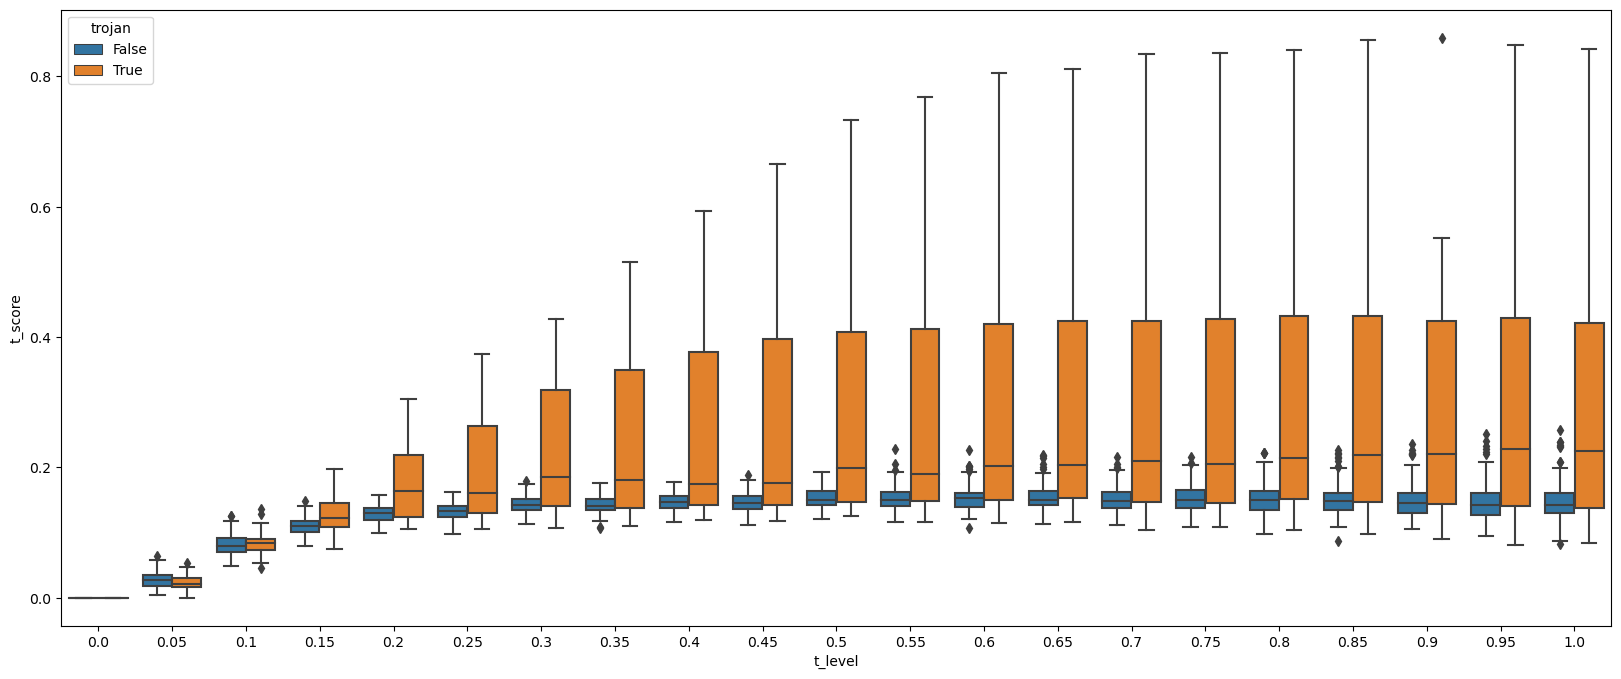

In [33]:
df = pd.DataFrame()
df['t_level'] = [t for t_level in t_levels for t in [str(round(t_level, 2))]*250]
df['t_score'] = [t for i in range(len(t_levels)) for t in all_t_scores[:, i].tolist()]
df['trojan'] = ([False]*125+[True]*125)*len(t_levels)

fig, ax = plt.subplots(figsize=(20,8))
sns.boxplot(data=df, x='t_level', y='t_score', hue='trojan');

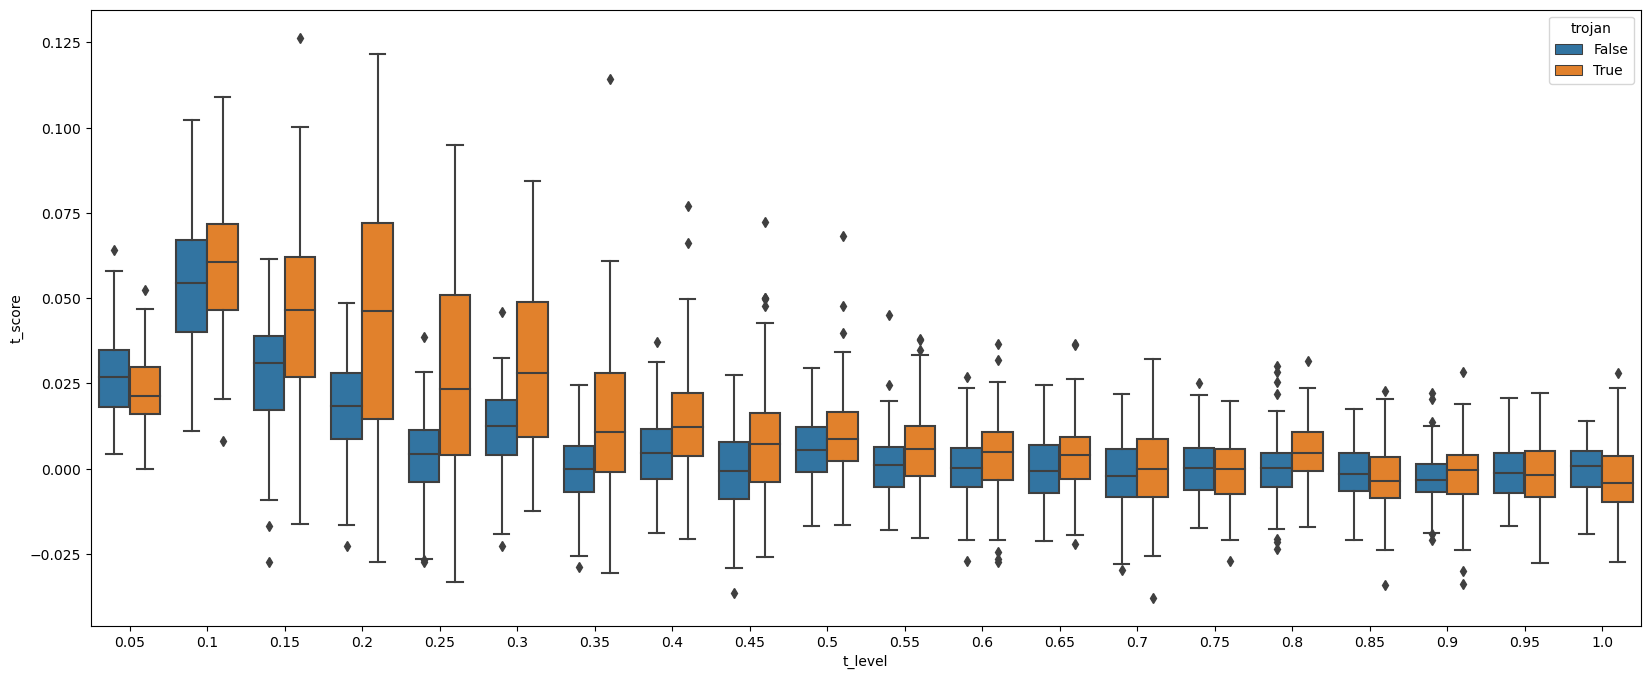

In [34]:
diff_t_scores = np.concatenate([np.diff(all_t_scores), t_scores_label], axis=1)
diff_t_levels = t_levels[1:]
diff_df = pd.DataFrame()
diff_df['t_level'] = [t for t_level in diff_t_levels for t in [str(round(t_level, 2))]*250]
diff_df['t_score'] = [t for i in range(len(diff_t_levels)) for t in diff_t_scores[:, i].tolist()]
diff_df['trojan'] = ([False]*125+[True]*125)*len(diff_t_levels)

fig, ax = plt.subplots(figsize=(20,8))
sns.boxplot(data=diff_df, x='t_level', y='t_score', hue='trojan');

In [35]:
t_score_with_diff = np.concatenate([all_t_scores, diff_t_scores], axis=1)
t_score_with_diff.shape

(250, 42)

## Feature Extraction

#### Aggregated Weight

In [5]:
norm_dict = {'MNIST_Network':['1', '4', '7', '11'], 'SimpleViT':['norm'], 'WideResNet':['bn']}

In [3]:
def extract_weight(model, extract_batchnorm=False):
    params = []
    for name, param in model.named_parameters():
        # if 'weight' in name:
        if extract_batchnorm:
            norm_names = norm_dict[model._get_name()]
            if any(n in name for n in norm_names):
                params.append(torch.abs(torch.mean(param)).detach().numpy())
        if not extract_batchnorm:
            # if len(param.shape) >= 3:
            if '3d' in name:
                axis = tuple(np.arange(len(param.shape)-1).tolist())
                params += torch.amax(param, dim=axis).flatten().tolist()
                params += torch.mean(param, dim=axis).flatten().tolist()
                sub = torch.mean(param, dim=axis).flatten() - torch.median(torch.flatten(param, end_dim=-2), dim=0).values.flatten()
                params += sub.tolist()
                params += torch.median(torch.flatten(param, end_dim=-2), dim=0).values.flatten().tolist()
                params += torch.sum(param, dim=axis).flatten().tolist()
                params += (torch.linalg.norm(param, ord='fro', dim=axis).flatten()**2/torch.linalg.norm(param, ord=2, dim=axis).flatten()**2).tolist()
            else:
                params.append(param.max().tolist())
                params.append(param.mean().tolist())
                sub = param.mean() - torch.median(param)
                params.append(sub.tolist())
                params.append(torch.median(param).tolist())
                params.append(param.sum().tolist())
                params.append((torch.linalg.norm(param.reshape(param.shape[0], -1), ord='fro')**2/torch.linalg.norm(param.reshape(param.shape[0], -1), ord=2)**2).tolist())
    return np.asarray(params)

#### Eigen Value

In [4]:
def extract_eigen(model):
    params = []
    num_param_per_layer = []
    min_shape = 1 if model._get_name() in ['SimpleViT', 'MNIST_Network'] else 2
    for param in model.parameters():
        if len(param.shape) > min_shape:
            reshaped_param = param.reshape(param.shape[0], -1)
            singular_values = torch.linalg.svd(reshaped_param, False).S
            squared_singular_values = torch.square(singular_values)
            ssv = squared_singular_values.tolist()
            params += ssv
            num_param_per_layer.append(len(ssv))
    return np.asarray(params), np.asarray(num_param_per_layer)

#### Directly load without saving locally

In [12]:
from itertools import product

def load_model_params(all_features, clean_or_trojan='clean', extraction_method=extract_weight, extract_batchnorm=False, model_filedir=MODEL_FILEDIR, add_label=True):
    for num in tqdm(range(NUM_MODEL)):
        model_filepath = os.path.join(model_filedir, clean_or_trojan, num_to_model_id(num), 'model.pt')
        with torch.no_grad():
            model = torch.load(model_filepath)
        model_class = model._get_name()
        if extraction_method == extract_eigen:
            params = extraction_method(model)
            eigen, layer = params[0], params[1]
            if add_label:
                eigen = np.append(eigen, [clean_or_trojan != 'clean'], axis=0)
            all_features[model_class+'_'+clean_or_trojan+'_eigen'].append(eigen)
            all_features[model_class+'_'+clean_or_trojan+'_layer'].append(layer)
        else: 
            params = extraction_method(model, extract_batchnorm=extract_batchnorm)               
            if add_label:
                params = np.append(params, [clean_or_trojan != 'clean'], axis=0)
            all_features[model_class+'_'+clean_or_trojan].append(params)
    for k, v in all_features.items():
        if len(v) != 0:
            all_features[k] = np.stack(v, axis=0)


In [41]:
weights = {mc+'_'+cot:[] for mc, cot in list(product(model_classes, clean_or_trojan))}

load_model_params(weights)
load_model_params(weights, 'trojan')

100%|██████████| 500/500 [02:35<00:00,  3.22it/s]


In [18]:
eigens = {mc+'_'+cot+'_'+eol:[] for mc, cot, eol in list(product(model_classes, clean_or_trojan, ['eigen', 'layer']))}

load_model_params(eigens, clean_or_trojan='clean', extraction_method=extract_eigen)
load_model_params(eigens, clean_or_trojan='trojan', extraction_method=extract_eigen)

100%|██████████| 500/500 [2:10:59<00:00, 15.72s/it]  


In [13]:
batchnorm_weights = {mc+'_'+cot:[] for mc, cot in list(product(model_classes, clean_or_trojan))}
load_model_params(batchnorm_weights, clean_or_trojan='clean', extraction_method=extract_weight, extract_batchnorm=True)
load_model_params(batchnorm_weights, clean_or_trojan='trojan', extraction_method=extract_weight, extract_batchnorm=True)

100%|██████████| 500/500 [00:11<00:00, 43.32it/s] 


#### To save and load the params from directory

In [ ]:
from itertools import product

def save_model_params_npy(clean_or_trojan='clean', extraction_method=extract_weight, model_filedir=MODEL_FILEDIR, extracted_dir=EXTRACTED_DIR):
    for num in tqdm(range(NUM_MODEL)):
        model_filepath = os.path.join(model_filedir, clean_or_trojan, num_to_model_id(num), 'model.pt')
        with torch.no_grad():
            model = torch.load(model_filepath)
        model_class = model._get_name()
        params = extraction_method(model)
        potential_dir = os.path.join(extracted_dir, clean_or_trojan, model_class)
        if os.path.exists(potential_dir):
            np.save(os.path.join(potential_dir, f'{num_to_model_id(num)}.npy'), params)
        else:
            os.mkdir(potential_dir)
            np.save(os.path.join(potential_dir, f'{num_to_model_id(num)}.npy'), params)

# save_model_params_npy()
# save_model_params_npy('trojan')


def load_all_model_params(all_features, extracted_dir=EXTRACTED_DIR, add_label=True):
    for key in all_features.keys():
        c_o_t = key.split('_')[-1]
        model_class = key.replace(c_o_t, '')
        params_dir = os.path.join(extracted_dir, c_o_t, model_class)
        features = []
        for param_dir in os.listdir(params_dir):
            model_param = np.load(os.path.join(params_dir, param_dir))
            features.append(model_param)
        features = np.stack(features, axis=0)
        if add_label:
            label = c_o_t != 'clean'
            labels = np.asarray([label] * features.shape[0]).reshape((features.shape[0], 1))
            features = np.append(features, labels, axis=1)
        all_features[key] = features
    return all_features

In [42]:
mnist_weight = np.concatenate((weights['MNIST_Network_clean'], weights['MNIST_Network_trojan']), axis=0)
vit_weight = np.concatenate((weights['SimpleViT_clean'], weights['SimpleViT_trojan']), axis=0)
wrn_weight = np.concatenate((weights['WideResNet_clean'], weights['WideResNet_trojan']), axis=0)

In [10]:
mnist_weight.shape, vit_weight.shape, wrn_weight.shape

((250, 109), (250, 397), (500, 697))

In [43]:
np.save('/scratch/jialin/trojan_detection/projects/tdc-starter-kit/detection/extracted_features/vit_weight.npy', vit_weight)
np.save('/scratch/jialin/trojan_detection/projects/tdc-starter-kit/detection/extracted_features/mnist_weight.npy', mnist_weight)
np.save('/scratch/jialin/trojan_detection/projects/tdc-starter-kit/detection/extracted_features/wrn_weight.npy', wrn_weight)

In [19]:
mnist_eigen = np.concatenate((eigens['MNIST_Network_clean_eigen'], eigens['MNIST_Network_trojan_eigen']), axis=0)
vit_eigen = np.concatenate((eigens['SimpleViT_clean_eigen'], eigens['SimpleViT_trojan_eigen']), axis=0)
wrn_eigen = np.concatenate((eigens['WideResNet_clean_eigen'], eigens['WideResNet_trojan_eigen']), axis=0)
mnist_eigen_layer = np.concatenate((eigens['MNIST_Network_clean_layer'], eigens['MNIST_Network_trojan_layer']), axis=0)
vit_eigen_layer = np.concatenate((eigens['SimpleViT_clean_layer'], eigens['SimpleViT_trojan_layer']), axis=0)
wrn_eigen_layer = np.concatenate((eigens['WideResNet_clean_layer'], eigens['WideResNet_trojan_layer']), axis=0)
np.save('/scratch/jialin/trojan_detection/projects/tdc-starter-kit/detection/extracted_features/vit_eigen.npy', vit_eigen)
np.save('/scratch/jialin/trojan_detection/projects/tdc-starter-kit/detection/extracted_features/mnist_eigen.npy', mnist_eigen)
np.save('/scratch/jialin/trojan_detection/projects/tdc-starter-kit/detection/extracted_features/wrn_eigen.npy', wrn_eigen)
np.save('/scratch/jialin/trojan_detection/projects/tdc-starter-kit/detection/extracted_features/vit_eigen_layer.npy', vit_eigen_layer)
np.save('/scratch/jialin/trojan_detection/projects/tdc-starter-kit/detection/extracted_features/mnist_eigen_layer.npy', mnist_eigen_layer)
np.save('/scratch/jialin/trojan_detection/projects/tdc-starter-kit/detection/extracted_features/wrn_eigen_layer.npy', wrn_eigen_layer)

In [20]:
mnist_eigen.shape, vit_eigen.shape, wrn_eigen.shape, mnist_eigen_layer.shape, vit_eigen_layer.shape, wrn_eigen_layer.shape

((250, 212), (250, 3164), (500, 2817), (250, 5), (250, 26), (500, 40))

In [14]:
mnist_bn = np.concatenate((batchnorm_weights['MNIST_Network_clean'], batchnorm_weights['MNIST_Network_trojan']), axis=0)
vit_bn = np.concatenate((batchnorm_weights['SimpleViT_clean'], batchnorm_weights['SimpleViT_trojan']), axis=0)
wrn_bn = np.concatenate((batchnorm_weights['WideResNet_clean'], batchnorm_weights['WideResNet_trojan']), axis=0)
np.save('/scratch/jialin/trojan_detection/projects/tdc-starter-kit/detection/extracted_features/vit_bn.npy', vit_bn)
np.save('/scratch/jialin/trojan_detection/projects/tdc-starter-kit/detection/extracted_features/mnist_bn.npy', mnist_bn)
np.save('/scratch/jialin/trojan_detection/projects/tdc-starter-kit/detection/extracted_features/wrn_bn.npy', wrn_bn)

In [15]:
mnist_bn.shape, vit_bn.shape, wrn_bn.shape

((250, 13), (250, 13), (500, 75))

In [49]:
mnist = np.concatenate((mnist_weight[:, :-1], mnist_eigen), axis=1)
vit = np.concatenate((vit_weight[:, :-1], vit_eigen), axis=1)
wrn = np.concatenate((wrn_weight[:, :-1], wrn_eigen), axis=1)

In [41]:
mnist_weight.shape, mnist_eigen.shape, vit_weight.shape, vit_eigen.shape, wrn_weight.shape, wrn_eigen.shape

((250, 91), (250, 212), (250, 331), (250, 3164), (500, 581), (500, 2817))

### Eigen Value Visualization

In [7]:
EXTRACTED_FILEDIR = '/scratch/jialin/trojan_detection/projects/tdc-starter-kit/detection/extracted_features/'
model_arch = ['mnist', 'vit', 'wrn']
layer_data = {ma: np.cumsum(np.load(os.path.join(EXTRACTED_FILEDIR, f'{ma}_eigen_layer.npy')), axis=1)[0] for ma in model_arch}
eigen_data = {ma: np.load(os.path.join(EXTRACTED_FILEDIR, f'{ma}_eigen.npy')) for ma in model_arch}
split_eigen_data = {ma: np.split(eigen_data[ma], layer_data[ma], axis=1) for ma in model_arch}

In [8]:
optimal_layers = {'mnist':[2, 3], 'vit':[0, 1, 2], 'wrn':[4, 15, 37, 39]}
optimal_eigen = {ma: [split_eigen_data[ma][num_layer] for num_layer in optimal_layers[ma]] for ma in model_arch}

In [25]:
layer_data['vit']

array([  48,  176,  304,  432,  560,  688,  816,  944, 1072, 1200, 1328,
       1456, 1584, 1712, 1840, 1968, 2096, 2224, 2352, 2480, 2608, 2736,
       2864, 2992, 3120, 3163])

In [22]:
eigen_data['mnist'][:, 41:201]

array([[1.47700417, 1.23648322, 1.07825041, ..., 0.18777421, 0.18731774,
        0.18139565],
       [1.47104204, 1.18420959, 1.08255649, ..., 0.19176582, 0.18883747,
        0.17908637],
       [1.244874  , 1.11012816, 1.00665116, ..., 0.19669527, 0.19003209,
        0.18192868],
       ...,
       [1.41810071, 1.17744267, 1.07067478, ..., 0.18903318, 0.18393445,
        0.17881076],
       [1.31854725, 1.27244806, 1.05340636, ..., 0.19098125, 0.18580104,
        0.1803873 ],
       [1.53335702, 1.22063303, 1.14916253, ..., 0.19770221, 0.1892125 ,
        0.18597688]])

In [28]:
top_eigen_data = {}
TOP_NUM = 10
for ma in model_arch:
    top_eigen = []
    ed = split_eigen_data[ma]
    for ind in range(len(ed)-1):
        top_each_layer = ed[ind][:, :TOP_NUM] if TOP_NUM <= ed[ind].shape[-1] else ed[ind]
        top_eigen.append(top_each_layer)
    top_eigen.append(ed[-1])
    top_eigen_data[ma] = np.concatenate(top_eigen, axis=1)

In [21]:
top_eigen_df = {}
for ma in model_arch:
    ted = top_eigen_data[ma]
    eigs = ted[:, :-1].flatten('C')
    eig_idx = [str(ind) for ind in range(1, ted.shape[-1])]*ted.shape[0]
    poisoned = np.reshape([[p]*(ted.shape[-1]-1) for p in ted[:, -1]], eigs.shape, 'C')
    df = pd.DataFrame({'eig_idx': eig_idx,
                        'eig_val': eigs,
                        'poisoned': poisoned})
    df['norm_eig_val'] = df.groupby(['eig_idx', 'poisoned'])[['eig_val']].transform(lambda x: (x - x.mean())/x.std())
    top_eigen_df[ma] = df

In [ ]:
sns.set(rc={'figure.figsize':(16,30)});
sns.boxplot(data=top_eigen_df['vit'], x='norm_eig_val', y='eig_idx', hue='poisoned');
# fig, axs = plt.subplots(ncols=3, figsize=(24,15))
# for ind, ax in enumerate(axs):
#     sns.boxplot(data=top_eigen_df[model_arch[ind]], x='norm_eig_val', y='eig_idx', hue='poisoned', ax=ax);
#     ax.set_title(model_arch[ind]+' models')

In [11]:
for t in top_eigen_data.values():
    print(t.shape)

(250, 50)
(250, 261)
(500, 401)


## Train / Tune the Models

In [31]:
from sklearn.metrics import log_loss
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

def bootstrap_performance(X, y, clf, n=10, test_size=.2, eps=.01):
    all_cross_entropy, all_accuracy = [], []
    for i in tqdm(range(n)):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=i)
        
        clf.set_params(random_state=i)            
        clf.fit(X_train, y_train)
        
        all_cross_entropy.append(log_loss(y_test, clf.predict_proba(X_test), eps=eps))
        all_accuracy.append(clf.score(X_test, y_test))
    return all_cross_entropy, all_accuracy

In [34]:
N = 30
clf = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.002)
result = {ma:[] for ma in model_arch}
for ma in model_arch:
    eigen_per_layer = split_eigen_data[ma][:-1]
    label = split_eigen_data[ma][-1].flatten()
    result_per_layer = []
    for epl in tqdm(eigen_per_layer):
        cen, acc = bootstrap_performance(epl, label, clf, n=N)
        result[ma].append((np.mean(cen), np.mean(acc)))

100%|██████████| 40/40 [1:39:50<00:00, 149.76s/it]


In [36]:
import json

with open('/scratch/jialin/trojan_detection/projects/tdc-starter-kit/detection/extracted_features/eigen_val_result.json', 'r') as outfile:
    json.dump(result, outfile)

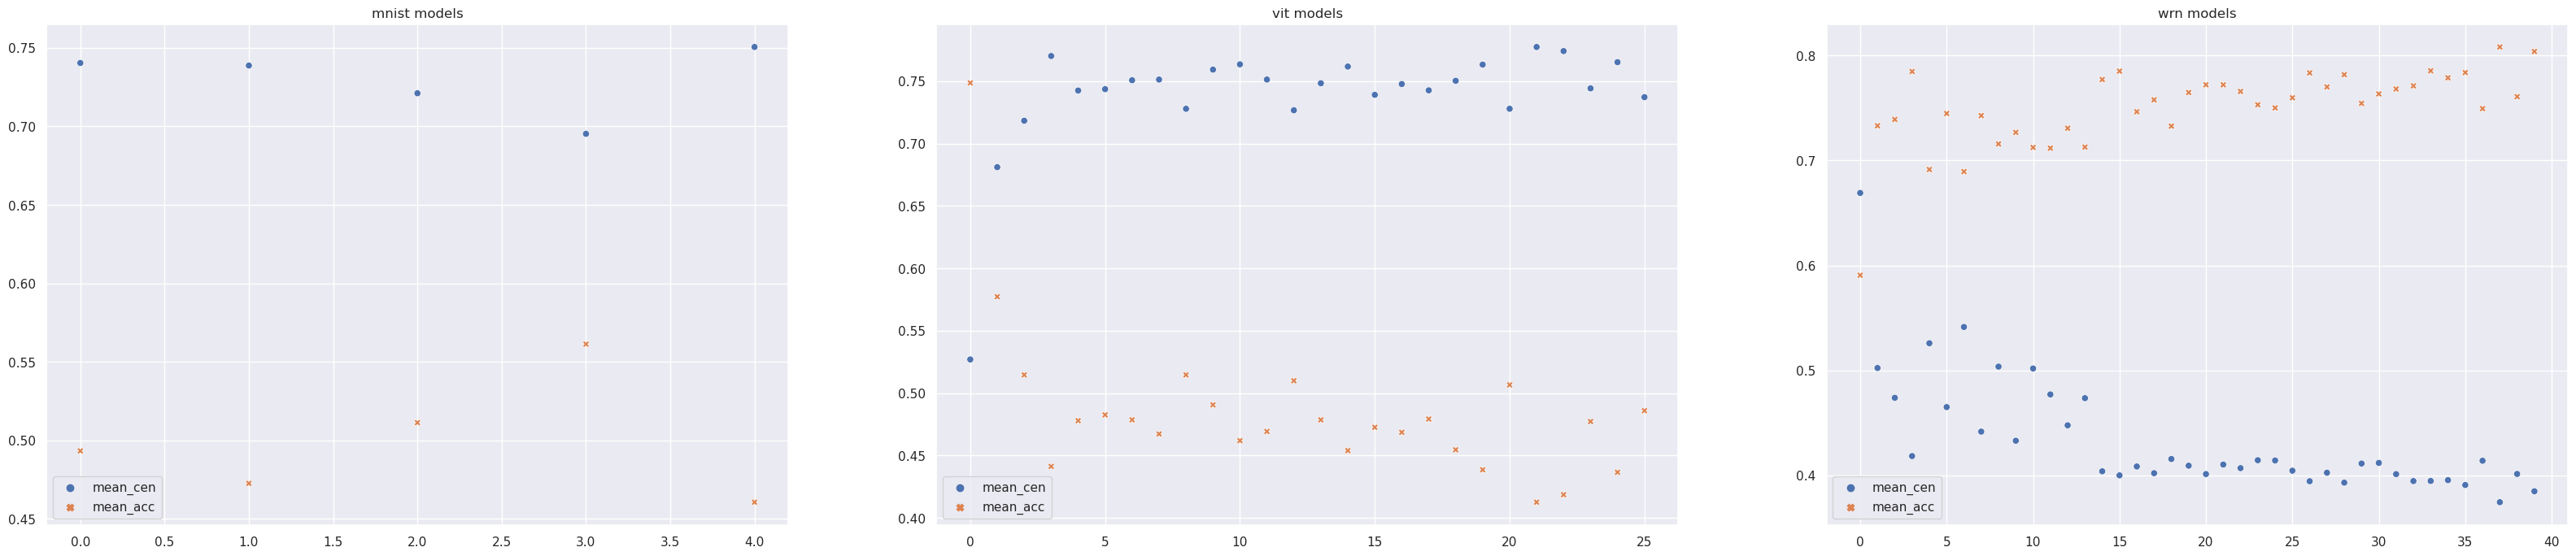

In [40]:
with open('/scratch/jialin/trojan_detection/projects/tdc-starter-kit/detection/extracted_features/eigen_val_result.json', 'r') as outfile:
    result = json.load(outfile)

# sns.set(rc={'figure.figsize':(16,30)});
fig, axs = plt.subplots(ncols=3, figsize=(40, 8))
for ind, ax in enumerate(axs):
    df = pd.DataFrame(result[model_arch[ind]])
    df.columns = ['mean_cen', 'mean_acc']
    sns.scatterplot(data=df, ax=ax);
    ax.set_title(model_arch[ind]+' models')

In [46]:
mnist_weight_with_norm = np.load('/scratch/jialin/trojan_detection/projects/tdc-starter-kit/detection/extracted_features/mnist_weight_with_norm.npy')
mnist_t_score = np.load('/scratch/jialin/trojan_detection/projects/tdc-starter-kit/detection/extracted_features/mnist_t_scores_gamma=98.npy')
mnist_t = np.concatenate([mnist_weight_with_norm[:, :-1], np.diff(mnist_t_score[:, :-1]), mnist_t_score], axis=1)

vit_weight_with_norm = np.load('/scratch/jialin/trojan_detection/projects/tdc-starter-kit/detection/extracted_features/vit_weight_with_norm.npy')
vit_t_score = np.load('/scratch/jialin/trojan_detection/projects/tdc-starter-kit/detection/extracted_features/vit_t_scores_gamma=98.npy')
vit_t = np.concatenate([vit_weight_with_norm[:, :-1], np.diff(vit_t_score[:, :-1]), vit_t_score], axis=1)

wrn_t = wrn_weight_with_norm

In [29]:
trigger_type_to_model_num = {}
for model_num in range(250, 375):
    info_filepath = os.path.join('/scratch/jialin/trojan_detection/projects/tdc_datasets/detection/train/trojan', num_to_model_id(model_num), 'info.json')
    with open(info_filepath, 'r') as f:
        curr_model_info = json.load(f)
        trigger_type = curr_model_info['trigger_type']
        if trigger_type not in trigger_type_to_model_num:
            trigger_type_to_model_num[trigger_type] = [model_num-250]
        else:
            trigger_type_to_model_num[trigger_type].append(model_num-250)

In [30]:
trigger_type_to_model_num['patch'] == list(range(63))

True

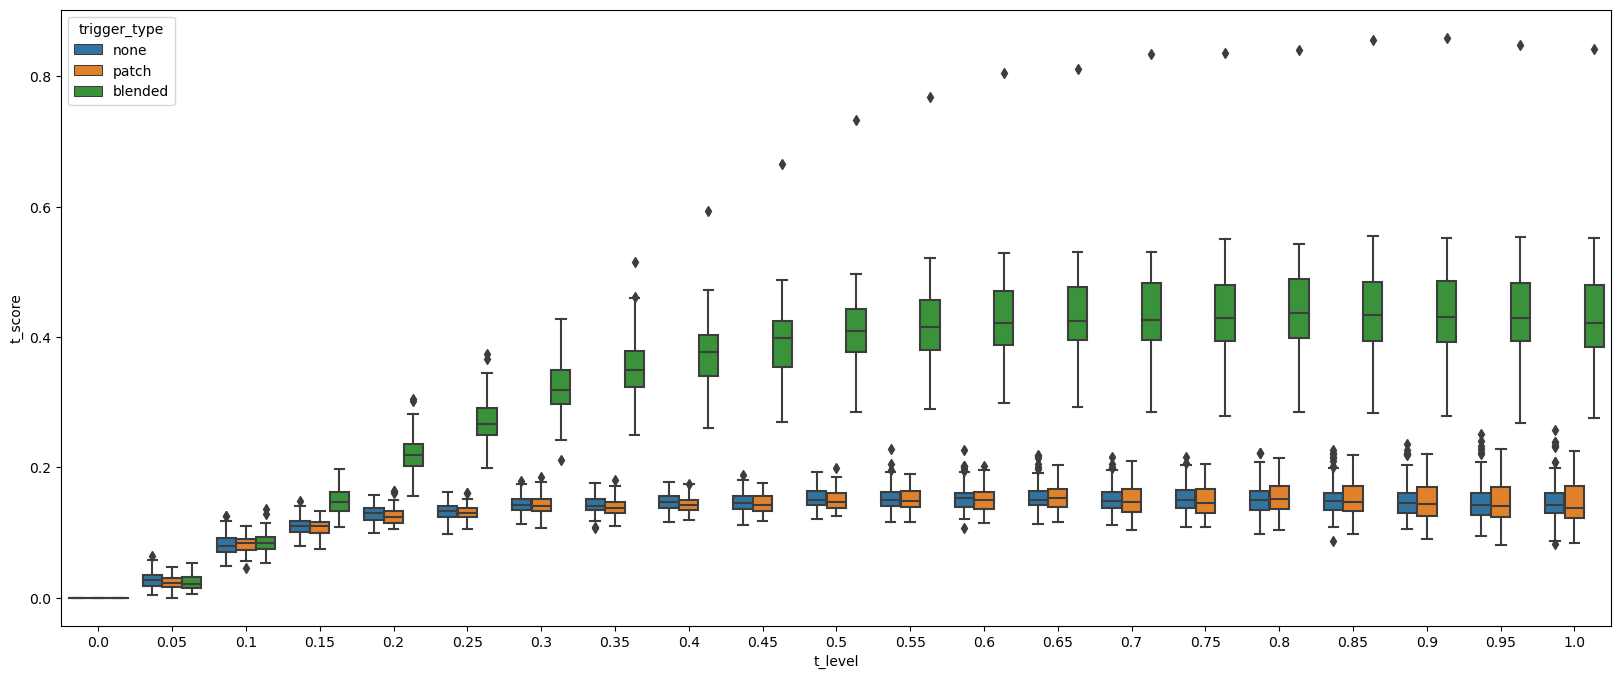

In [32]:
# patch - (375-437), blended - (438-)
import seaborn as sns
import pandas as pd

t_levels = np.arange(0, 1.01, .05)
df = pd.DataFrame()
df['t_level'] = [t for t_level in t_levels for t in [str(round(t_level, 2))]*250]
df['t_score'] = [t for i in range(len(t_levels)) for t in vit_t_score[:, i].tolist()]
df['trojan'] = ([False]*125+[True]*125)*len(t_levels)
df['trigger_type'] = (['none']*125+['patch']*63+['blended']*62)*len(t_levels)

fig, ax = plt.subplots(figsize=(20,8))
sns.boxplot(data=df, x='t_level', y='t_score', hue='trigger_type');

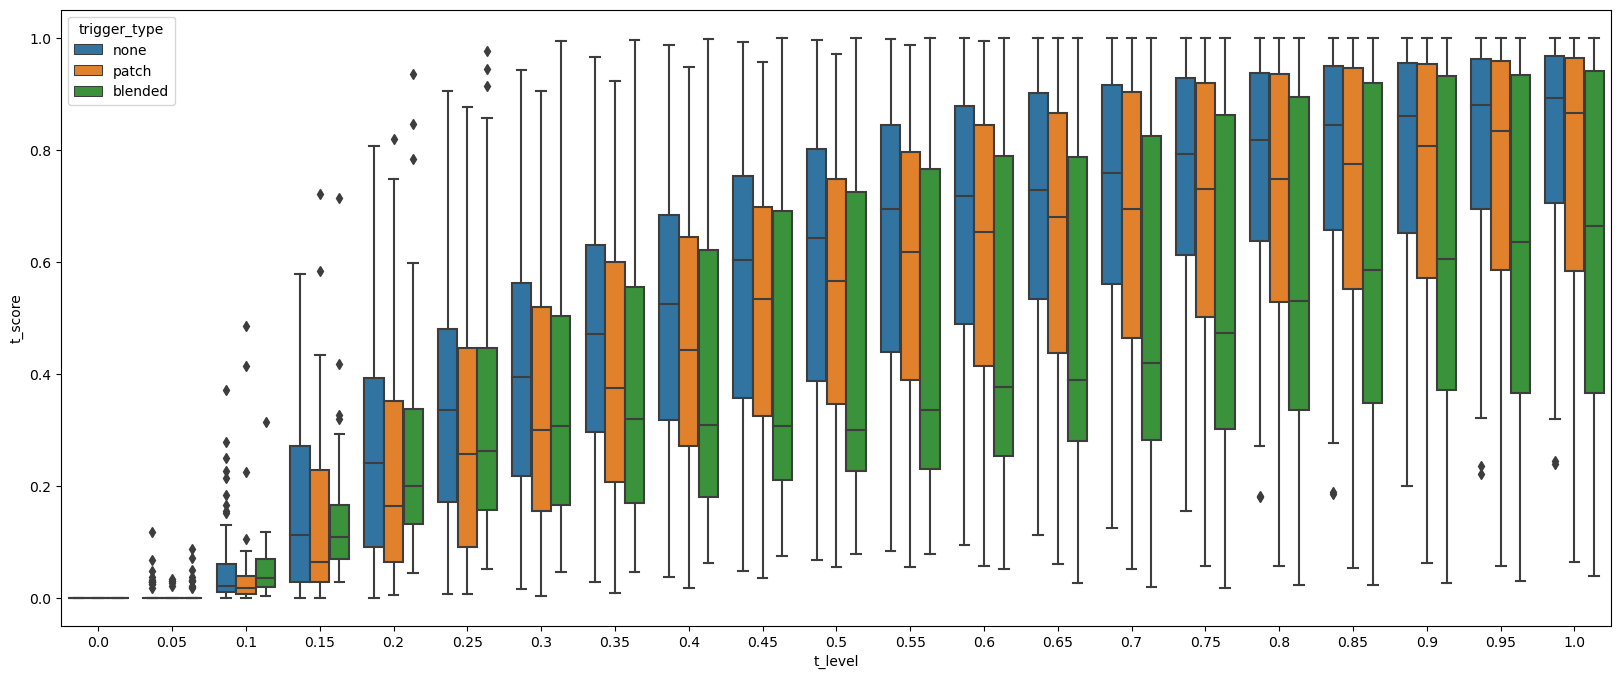

In [31]:
# patch - (250-312), blended - (312-374) inclusive
import seaborn as sns
import pandas as pd

t_levels = np.arange(0, 1.01, .05)
df = pd.DataFrame()
df['t_level'] = [t for t_level in t_levels for t in [str(round(t_level, 2))]*250]
df['t_score'] = [t for i in range(len(t_levels)) for t in mnist_t_score[:, i].tolist()]
df['trojan'] = ([False]*125+[True]*125)*len(t_levels)
df['trigger_type'] = (['none']*125+['patch']*63+['blended']*62)*len(t_levels)

fig, ax = plt.subplots(figsize=(20,8))
sns.boxplot(data=df, x='t_level', y='t_score', hue='trigger_type');

In [27]:
clf = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.002)
X_train, X_test, y_train, y_test = train_test_split(np.concatenate(optimal_eigen['vit'][:3], axis=1), vit_weight[:, -1], test_size=.2)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.72

In [7]:
mnist_weight = np.load(os.path.join(EXTRACTED_FILEDIR, 'mnist_weight_with_norm.npy'))
vit_weight = np.load(os.path.join(EXTRACTED_FILEDIR, 'vit_weight_with_norm.npy'))
mnist_eigen = optimal_eigen['mnist']
vit_eigen = optimal_eigen['vit']
mnist_features = np.concatenate([mnist_weight[:, :-1], np.concatenate(mnist_eigen, axis=1)], axis=1)
vit_features = np.concatenate([vit_weight[:, :-1], np.concatenate(vit_eigen, axis=1)], axis=1)
mnist_features.shape, vit_features.shape

((250, 268), (250, 700))

In [8]:
N = 50
clf_A = GradientBoostingClassifier(learning_rate=.003, n_estimators=1500, min_samples_split=160, min_samples_leaf=18, max_depth=5, max_features=28)     # cen - .47149433, acc - .7916 
clf_B = GradientBoostingClassifier(learning_rate=.0035, n_estimators=1000, max_depth= 7, min_samples_leaf= 10, min_samples_split= 75, max_features=165, subsample=.98)      # cen - .48890442, acc - .75
result = []
result += list(bootstrap_performance(mnist_features, mnist_weight[:, -1], clf_A, n=N))
result += list(bootstrap_performance(vit_features, vit_weight[:, -1], clf_B, n=N))
# result += list(bootstrap_performance(wrn_t[:, :-1], wrn_t[:, -1], clf, n=N))
np.mean(result, axis=1)
# 0.50044675, 0.77133333, 0.45736496, 0.79466667 - weight, eigen, batch norm, tdiff, tscore
# 0.50969904, 0.768     , 0.52291596, 0.752 - without tdiff and tscore
# 0.50285352, 0.75733333, 0.45645858, 0.798 - with limited eigen
# 0.50030608, 0.77066667, 0.45636384, 0.79666667 - without batch norm

100%|██████████| 50/50 [06:00<00:00,  7.20s/it]


array([0.52034617, 0.7688    , 0.47320997, 0.7808    ])

In [23]:
np.argsort(clf.feature_importances_)[::-1][:10]
# np.sort(clf.feature_importances_)[::-1][:10]

array([406, 418, 390,  12, 419, 656, 425, 408, 321, 450])

In [30]:
vit_weight_with_rn = np.load('/scratch/jialin/trojan_detection/projects/tdc-starter-kit/detection/extracted_features/vit_weight_with_rn_5nl.npy')
vit_weight_with_rn = vit_weight_with_rn[:, 43:]
vit_weight_with_norm_and_rn = np.concatenate([vit_weight_with_rn[:, :4*43], vit_weight_with_norm], axis=1)
vit_weight_with_norm_and_rn.shape

(250, 569)

In [32]:

result += list(bootstrap_performance(vit_weight_with_norm_and_rn[:, :-1], vit_weight_with_norm_and_rn[:, -1], clf, n=N))
np.mean(result, axis=1)

100%|██████████| 30/30 [10:32<00:00, 21.08s/it]


array([0.69206674, 0.76466667, 0.67905907, 0.778     , 0.91448034,
       0.66533333, 0.98347907, 0.62666667, 0.75447109, 0.73133333,
       0.77516751, 0.74466667])

In [27]:
import pandas as pd

means = np.mean(result, axis=1)
df = pd.DataFrame.from_dict({'mnist_weight_with_norm': [means[0], means[1]], 
                            'mnist_weight': [means[2], means[3]], 
                            'vit_weight_with_norm': [means[4], means[5]],
                            'vit_weight': [means[6], means[7]],
                            'vit_current_features': [means[8], means[9]]}, orient='index')
df.columns = ['cross_entropy', 'accuracy']
df

,cross_entropy,accuracy
mnist_weight_with_norm,0.692067,0.764667
mnist_weight,0.679059,0.778000
vit_weight_with_norm,0.914480,0.665333
vit_weight,0.983479,0.626667
vit_current_features,0.754471,0.731333


In [29]:
vit_weight_with_rn.shape, vit_weight.shape

((250, 503), (250, 331))

In [ ]:
clf_A = GradientBoostingClassifier(learning_rate=.003, n_estimators=1500, min_samples_split=160, min_samples_leaf=18, max_depth=5, max_features=28)     # cen - .47149433, acc - .7916 
clf_B = GradientBoostingClassifier(learning_rate=.0035, n_estimators=1000, max_depth= 7, min_samples_leaf= 10, min_samples_split= 75, max_features=165, subsample=.98)      # cen - .48890442, acc - .75
param = {'max_depth': range(5, 16, 2), 'min_samples_leaf':range(10, 101, 10), 'min_samples_split': range(50, 601, 50)}   #
gsearch = GridSearchCV(estimator=clf_A, param_grid=param, scoring=['neg_log_loss', 'accuracy'], n_jobs=10, cv=5, refit=False);
gsearch.fit(mnist[:, :-1], mnist[:, -1]);

In [ ]:
result = pd.DataFrame(gsearch.cv_results_).sort_values(by=['rank_test_accuracy', 'rank_test_neg_log_loss'])
result.to_csv('/scratch/jialin/trojan_detection/projects/tdc-starter-kit/detection/extracted_features/gsearch_result.csv')

## Feeding Random Noise

In [113]:
import torch
from torch.utils.data import DataLoader

def random_noise_generator(channel=None, resolution=None, num_of_datapts=1000, generate_method='random_noise', noise_level=1, input_data=None):
    processed_data = None
    if input_data is None:
        features = torch.rand(num_of_datapts, channel, resolution, resolution)
    elif 'torchvision.datasets' in str(input_data.__class__):
        dataloader = DataLoader(input_data, batch_size=num_of_datapts, shuffle=True)
        features, _ = next(iter(dataloader))
    if generate_method == 'random_noise':
        random_noise = torch.rand(num_of_datapts, channel, resolution, resolution)
        processed_data = features + random_noise*noise_level
    elif generate_method == 'gaussian_blur':
        blurrer = T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
        # blurrer = T.GaussianBlur(kernel_size=resolution-1)
        rnd_idx = np.random.permutation(num_of_datapts)[:int(num_of_datapts*noise_level)]
        processed_data = features
        processed_data[rnd_idx, :] = blurrer(features[rnd_idx, :])
    # min_data = processed_data.min(dim=3, keepdim=True).values.min(dim=2, keepdim=True).values.min(dim=1, keepdim=True).values
    # max_data = processed_data.max(dim=3, keepdim=True).values.max(dim=2, keepdim=True).values.max(dim=1, keepdim=True).values
    # processed_data = (processed_data - min_data)/(max_data - min_data)
    return processed_data

In [6]:
def extract_prob(model, random_noise):
    with torch.no_grad():
        curr_model = model.to(device)
        random_noise = random_noise.to(device)
        output = curr_model(random_noise).softmax(dim=-1).mean(dim=0)
    del curr_model, random_noise
    return output.cpu().detach().numpy()

In [62]:
def extract_info_for_model_input(clean_or_trojan, model_id):
    curr_model_dir = os.path.join(MODEL_FILEDIR, clean_or_trojan, num_to_model_id(model_id))
    with open(os.path.join(curr_model_dir, 'info.json'), 'r') as f:
        curr_model_info = json.load(f)
        resolution = curr_model_info['input_resolution']
        channel = 1 if curr_model_info['dataset'] == 'MNIST' else 3
    return channel, resolution

def extract_prob_from_models(clean_or_trojan, model_id, random_noise):
    curr_model_dir = os.path.join(MODEL_FILEDIR, clean_or_trojan, num_to_model_id(model_id))
    with torch.no_grad():
        curr_model = torch.load(os.path.join(curr_model_dir, 'model.pt')).to(device)
        random_noise = random_noise.to(device)
        output = curr_model(random_noise).softmax(dim=-1).mean(dim=0)
    return output.cpu().detach().numpy()

In [146]:
model_type = 'vit'
model_dict = {'mnist': (1, 28, range(375, 500), mnist_ds, [0.0, .5, 1]), 
                'vit': (3, 32, range(250, 375), gtsrb_ds, [.25, .5, .75, 1]), 
                'wrn_10': (3, 32, range(0, 125), cifar10_ds), 
                'wrn_100': (3, 32, range(125, 250), cifar100_ds)}
cha, res, model_nums, ds, noise_levels = model_dict[model_type]
iters = 2
clean_model_avgs, trojan_model_avgs = [], []
for nl in noise_levels:
    for model_num in tqdm(model_nums):
        clean_outputs, trojan_outputs = [], []
        for _ in range(iters):
            random_noise_c = random_noise_generator(cha, res, generate_method='random_noise', num_of_datapts=3000, input_data=ds, noise_level=nl)
            random_noise_t = random_noise_generator(cha, res, generate_method='random_noise', num_of_datapts=3000, input_data=ds, noise_level=nl)
            clean_outputs.append(extract_prob_from_models('clean', model_num, random_noise_c))
            trojan_outputs.append(extract_prob_from_models('trojan', model_num, random_noise_t))
        clean_model_avgs.append(np.stack(clean_outputs, axis=0).mean(axis=0))
        trojan_model_avgs.append(np.stack(trojan_outputs, axis=0).mean(axis=0))

100%|██████████| 125/125 [11:48<00:00,  5.67s/it]


In [147]:
model_sep = np.array(list(range(len(noise_levels)+1)))*125

In [115]:
clean_avgs, trojan_avgs = [], []
for i in range(len(noise_levels)):
    clean_avgs.append(np.stack(clean_model_avgs[model_sep[i]: model_sep[i+1]], axis=0).mean(axis=0))
    trojan_avgs.append(np.stack(trojan_model_avgs[model_sep[i]: model_sep[i+1]], axis=0).mean(axis=0))

In [148]:
clean_model_nl, trojan_model_nl = clean_model_avgs[0:125], trojan_model_avgs[0:125]
for i in range(1, len(noise_levels)):
    clean_model_nl = np.concatenate([clean_model_nl, clean_model_avgs[model_sep[i]: model_sep[i+1]]], axis=1)
    trojan_model_nl = np.concatenate([trojan_model_nl, trojan_model_avgs[model_sep[i]: model_sep[i+1]]], axis=1)

In [149]:
feature = np.concatenate([clean_model_nl, trojan_model_nl], axis=0)
label = [False]*125 + [True]*125
feature.shape, len(label)

((250, 215), 250)

In [166]:
vit_weight_with_feature = np.concatenate((feature[:, 43:], vit_weight), axis=1)
vit_weight_with_feature.shape

(250, 503)

In [15]:
mnist_weight = np.load('/scratch/jialin/trojan_detection/projects/tdc-starter-kit/detection/extracted_features/mnist_weight.npy')
mnist_tatt = np.load('/scratch/jialin/trojan_detection/projects/tdc-starter-kit/detection/extracted_features/mnist_TrojanAttack.npy')

In [7]:
mnist_X = np.concatenate([mnist_tatt, mnist_weight[:, :-1]], axis=1)
mnist_y = mnist_weight[:, -1]
mnist_X.shape

(250, 106)

In [167]:
clf = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.02)
X_train, X_test, y_train, y_test = train_test_split(vit_weight_with_feature[:, :-1], vit_weight_with_feature[:, -1], test_size=.2)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.82

In [13]:
result = []
clf = GradientBoostingClassifier(n_estimators=2000, learning_rate=0.02)
result += list(bootstrap_performance(mnist_weight[:, :-1], mnist_weight[:, -1], clf, n=20))
result += list(bootstrap_performance(mnist_X, mnist_y, clf, n=20))
np.mean(result, axis=1)

100%|██████████| 20/20 [02:47<00:00,  8.38s/it]


array([0.834785  , 0.763     , 0.77335695, 0.779     ])

In [ ]:
np.argsort(clf.feature_importances_)[::-1]

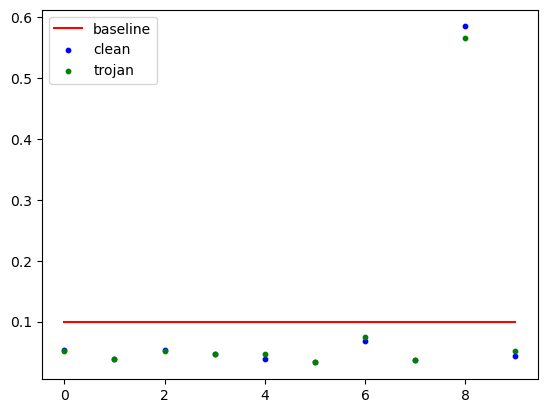

In [93]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()


clean_avg = np.stack(clean_model_avgs, axis=0).mean(axis=0)
trojan_avg = np.stack(trojan_model_avgs, axis=0).mean(axis=0)
num_classes = 10
baseline = [1/num_classes]*num_classes
xlabel = list(range(num_classes))
ax.plot(xlabel, baseline, c='red', label='baseline')
ax.scatter(xlabel, clean_avg, c='blue', label='clean', s=10)
ax.scatter(xlabel, trojan_avg, c='green', label='trojan', s=10)

plt.legend()
plt.show()

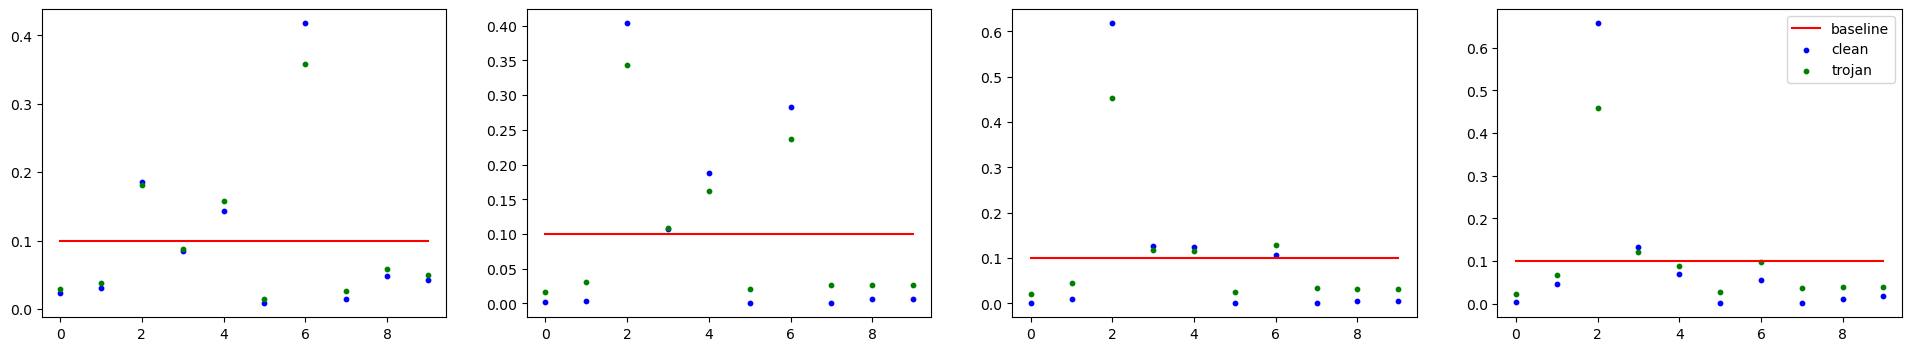

In [42]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(24, 4))

for ind, ax in enumerate(axs):
    clean_avg = clean_avgs[ind]
    trojan_avg = trojan_avgs[ind]
    num_classes = clean_avg.shape[0]
    baseline = [1/num_classes]*num_classes
    xlabel = list(range(num_classes))
    ax.plot(xlabel, baseline, c='red', label='baseline')
    ax.scatter(xlabel, clean_avg, c='blue', label='clean', s=10)
    ax.scatter(xlabel, trojan_avg, c='green', label='trojan', s=10)

plt.legend()
plt.show()

# Submission

In [9]:
mnist_weight = np.load(os.path.join(EXTRACTED_FILEDIR, 'mnist_weight_with_norm.npy'))
vit_weight = np.load(os.path.join(EXTRACTED_FILEDIR, 'vit_weight_with_norm.npy'))
mnist_eigen = optimal_eigen['mnist']
vit_eigen = optimal_eigen['vit']
mnist = np.concatenate([mnist_weight[:, :-1], np.concatenate(mnist_eigen, axis=1), mnist_weight[:, -1].reshape(-1, 1)], axis=1)
vit = np.concatenate([vit_weight[:, :-1], np.concatenate(vit_eigen, axis=1), vit_weight[:, -1].reshape(-1, 1)], axis=1)
wrn = np.load('/scratch/jialin/trojan_detection/projects/tdc-starter-kit/detection/extracted_features/wrn_weight_with_norm.npy')
optimal_eigen_idx = {'MNIST_Network':(41, 201), 'SimpleViT':(0, 304)}

In [10]:
mnist.shape, vit.shape, wrn.shape

((250, 269), (250, 701), (500, 697))

In [25]:
clf_A = GradientBoostingClassifier(learning_rate=.006, n_estimators=750, min_samples_split=57, min_samples_leaf=7, max_depth=4, max_features=40)     # 1, 10, 30 
clf_B = GradientBoostingClassifier(learning_rate=.015, n_estimators=500, min_samples_leaf= 10, min_samples_split= 75)      # .0035 1000
param = {'max_depth': range(1, 6), 'min_samples_leaf':range(2, 31, 3), 'min_samples_split': range(2, 81, 5)}   #max_features=165, subsample=.98
gsearch = GridSearchCV(estimator=clf_B, param_grid=param, scoring=['neg_log_loss', 'accuracy'], n_jobs=10, cv=5, refit=False);
gsearch.fit(vit[:, :-1], vit[:, -1]);

KeyboardInterrupt: 

In [ ]:
result = pd.DataFrame(gsearch.cv_results_).sort_values(by=['rank_test_accuracy', 'rank_test_neg_log_loss'])
result.to_csv('/scratch/jialin/trojan_detection/projects/tdc-starter-kit/detection/extracted_features/gsearch_result.csv')

In [18]:
from sklearn.ensemble import GradientBoostingClassifier

clf_A = GradientBoostingClassifier(learning_rate=.003, n_estimators=1500, min_samples_split=160, min_samples_leaf=18, max_depth=5, max_features=28)     # cen - .47149433, acc - .7916 
clf_B = GradientBoostingClassifier(learning_rate=.0035, n_estimators=1000, max_depth= 7, min_samples_leaf= 10, min_samples_split= 75, max_features=165, subsample=.98)      # cen - .48890442, acc - .75
clf_C = GradientBoostingClassifier(learning_rate=.05, n_estimators=700)     # cen - .01352295, acc - .999
clf_A.fit(mnist[:, :-1], mnist[:, -1])
clf_B.fit(vit[:, :-1], vit[:, -1])
clf_C.fit(wrn[:, :-1], wrn[:, -1])
model_class_to_clf = {'MNIST_Network': clf_A, 'SimpleViT': clf_B, 'WideResNet': clf_C}
# model_dict = {'MNIST_Network': (1, 28, range(375, 500), mnist_ds), 
#                 'SimpleViT': (3, 32, range(250, 375), gtsrb_ds, np.arange(0, 1.01, .05), .98)}

In [31]:
valid_dir = os.path.join(dataset_path, task, 'val')
scores = []
for i in tqdm(range(1000)):
    model_id = num_to_model_id(i)
    model_path = os.path.join(valid_dir, model_id, 'model.pt')
    with torch.no_grad():
        model = torch.load(model_path)
    model_class = model._get_name()
    extracted_features = extract_weight(model)
    if model_class in ['SimpleViT', 'MNIST_Network']:
        eigen, _ = extract_eigen(model)
        opt_idx_s, opt_idx_e = optimal_eigen_idx[model_class]
        optimal_eigen_features = eigen[opt_idx_s:opt_idx_e]
        extracted_features = np.concatenate([extracted_features, optimal_eigen_features])
    extracted_features = extracted_features.reshape((1, -1))
    clf = model_class_to_clf[model_class]
    prob = clf.predict_proba(extracted_features)[0, -1]
    scores.append(prob)

100%|██████████| 1000/1000 [3:11:27<00:00, 11.49s/it] 


In [32]:
with open(os.path.join('mntd_submission', 'predictions.npy'), 'wb') as f:
    np.save(f, np.array(scores))
    
!cd mntd_submission && zip ../mntd_submission.zip ./* && cd ..

updating: predictions.npy (deflated 45%)


In [3]:
pred = np.load(os.path.join('mntd_submission', 'predictions.npy'))
pred[:5]  #[3.09753609e-16, 9.58393766e-01, 3.09753609e-16, 3.80276671e-01, 3.89319414e-02]

array([3.09753609e-16, 8.90006731e-01, 3.09753609e-16, 4.69300800e-01,
       2.77037712e-01])

In [18]:
T = 0.3
pred_new = np.stack([pred, np.abs(1-pred)], axis=1)
pred_updated = np.exp(np.log(pred_new)/T)/np.exp(np.log(pred_new)/T).sum(axis=1).reshape([-1, 1])
pred_updated = pred_updated[:, 0]
print(pred_updated[:5])
with open(os.path.join('mntd_submission', 'predictions.npy'), 'wb') as f:
    np.save(f, np.array(pred_updated))
    
!cd mntd_submission && zip ../mntd_submission.zip ./* && cd ..

[2.01088816e-52 9.99060635e-01 2.01088816e-52 3.98950922e-01
 3.92657675e-02]
updating: predictions.npy (deflated 45%)


1. see titration analysis work independently
2. see t-score difference separated on both triggers